# Speed up OPs with System Optimizations

In the previous notebook, we are already familiar with how to develop your own OP.

For most text-only OPs, the running speed of them is usually very fast. But for multimodal datasets and OPs, we often need to integrate some excellent existing models to help clean/synthesize data. Therefore, the efficiency of these OPs might become a bottleneck in the whole data processing pipeline due to some compute-intensive subprocedures and large model inference.

Luckily, Data-Juicer already conducts several system optimization on OPs to speed up their processing, such as CUDA support, OP fusion, and so on. In this notebook, we will check how to enable these optimization strategies in OPs and how they work.

## Test Dataset Preparation

Here we prepare a test dataset to check system optimizations on OPs, which contains 10k image-text pairs.

We just need to download to the current directory.

In [6]:
!wget http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_test_data.tar.gz && tar zxf tutorial_test_data.tar.gz && rm -rf tutorial_test_data.tar.gz

--2024-08-09 06:40:56--  http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_test_data.tar.gz
Resolving dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)... 39.101.35.6
Connecting to dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)|39.101.35.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466663769 (445M) [application/gzip]
Saving to: ‘tutorial_test_data.tar.gz’

tutorial_test_data. 100%[===================>] 445.04M  24.5MB/s    in 13s     

2024-08-09 06:41:09 (34.5 MB/s) - ‘tutorial_test_data.tar.gz’ saved [466663769/466663769]



Then we can check the basic format of this dataset.

In [1]:
import os
from jsonargparse import dict_to_namespace
from data_juicer.format.load import load_formatter
# replace the dataset path to your correct version
dataset_path = './tutorial_test_data/tutorial_test.jsonl'

formatter = load_formatter(dataset_path, text_keys='text')
dataset = formatter.load_dataset(global_cfg=dict_to_namespace({
    'dataset_dir': os.path.dirname(dataset_path),
    'video_key': 'videos',
    'image_key': 'images',
    'audio_key': 'audios',
}))
print(dataset)

/usr/local/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating jsonl split: 10000 examples [00:00, 943112.45 examples/s]
2024-08-09 14:57:27.519 | INFO     | data_juicer.format.formatter:unify_format:185 - Unifying the input dataset formats...
2024-08-09 14:57:27.520 | INFO     | data_juicer.format.formatter:unify_format:200 - There are 10000 sample(s) in the original dataset.
Filter: 100%|██████████| 10000/10000 [00:00<00:00, 90626.52 examples/s]
2024-08-09 14:57:27.633 | INFO     | data_juicer.format.formatter:unify_format:214 - 10000 samples left after filtering empty text.
2024-08-09 14:57:27.633 | INFO     | data_juicer.format.formatter:unify_format:237 - Converting relative paths in the dataset to their absolute version. (Based on the directory of input dataset file)
Map: 100%|███

Dataset({
    features: ['id', 'text', 'images'],
    num_rows: 10000
})


## CUDA Support

For those OPs who apply some other models to help to clean, filter, synthesize data, it usually takes lots of time for model inference on CPUs. Therefore, Data-Juicer supports CUDA for these OPs to enable parallel computation on GPUs.

Here we take a image-related OP `image_aesthetics_filter` as the example to show you how CUDA is supported in Data-Juicer. This OP scores images in the dataset from the aesthetics perspective with an existing model `shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE`. The implementation of this OP can be found [here](https://github.com/modelscope/data-juicer/blob/main/data_juicer/ops/filter/image_aesthetics_filter.py).

We prepare a test data recipe to apply this OP on the test dataset. For the first version, we run this OP in CPU mode.

In [4]:
cpu_recipe = '''
project_name: 'cpu_mode_test'
dataset_path: './tutorial_test_data/tutorial_test.jsonl'
export_path: './outputs/cpu_mode/res.jsonl'
np: 24

# we need to experiment for several times, so we need to close cache management
# to guarantee all these exps run the OP indeed.
use_cache: false

# you can replace the model path with a local path on your machine
process:
  - image_aesthetics_filter:
      hf_scorer_model: shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE
      min_score: 0.3
      max_score: 1.0
      accelerator: 'cpu'  # run the model inference with CPUs
'''

with open('cpu_mode.yaml', 'w') as fout:
    fout.write(cpu_recipe)

Then we run this recipe with `dj-process` command.

In [1]:
!dj-process --config cpu_mode.yaml

2024-08-09 16:01:05 | WARNING  | data_juicer.config.config:405 - Cache management of datasets is disabled.
2024-08-09 16:01:05 | WARNING  | data_juicer.config.config:416 - Set temp directory to store temp files to [None].
2024-08-09 16:01:06 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/cpu_mode.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/cpu_mode]
2024-08-09 16:01:06 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                                                            │
╞═════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                  │ [Path_f

As we can see, the data processing for the whole dataset costs **503.302s (8min23s)** in total in CPU mode using 24 subprocesses, which is relatively not very fast. Because if we want to process some larger-scale datasets (e.g. CC3M with nearly 3 million image-text pairs), it might take several days, let alone those larger and slower models.

Now let's replace the accelerator of this OP with CUDA and check its speed. We run this experiment on a machine with 8 GPUs. As we benchmarked this model before, one aesthetics predictor model requires about 1500MB GPU memory, so we need to set the "mem_required" in addition.

In [2]:
cuda_recipe = '''
project_name: 'cpu_mode_test'
dataset_path: './tutorial_test_data/tutorial_test.jsonl'
export_path: './outputs/cpu_mode/res.jsonl'
np: 24

# we need to experiment for several times, so we need to close cache management
# to guarantee all these exps run the OP indeed.
use_cache: false

# you can replace the model path with a local path on your machine
process:
  - image_aesthetics_filter:
      hf_scorer_model: shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE
      min_score: 0.3
      max_score: 1.0
      accelerator: 'cuda'  # run the model inference with CUDA
      mem_required: '1500MB'  # set the GPU memory requirements for this model
'''

with open('cuda_mode.yaml', 'w') as fout:
    fout.write(cuda_recipe)

Then we run this recipe with `dj-process` command.

In [3]:
!dj-process --config cuda_mode.yaml

2024-08-09 16:11:22 | WARNING  | data_juicer.config.config:405 - Cache management of datasets is disabled.
2024-08-09 16:11:22 | WARNING  | data_juicer.config.config:416 - Set temp directory to store temp files to [None].
2024-08-09 16:11:22 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/cuda_mode.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/cpu_mode]
2024-08-09 16:11:22 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                                                            │
╞═════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                  │ [Path_

As we can see, the data processing for the whole dataset only costs **42.510s** in total in CUDA mode using 24 subprocesses, which is much faster than CPU mode and the speed-up ratio is nearly **12x**.

In CUDA mode, we use the same number of subprocesses as in CPU mode. For 8 GPUs, Data-Juicer allocate 3 models on each GPU (GPU mem occupation 4600MiB is nearly 3 times of the memory requirement of a single model).

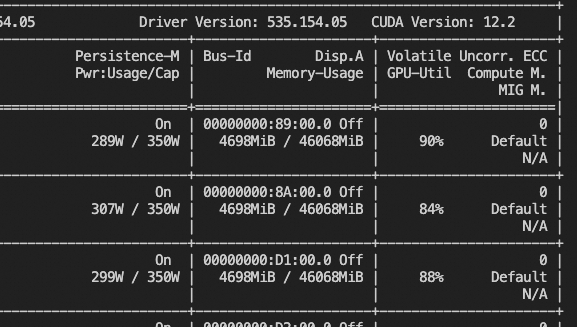

Theoretically, we can continue to increase the number of subprocesses to fully make use of GPUs and obtain more speed-up.

Data-Juicer set the `accelerator` of those model-based OPs to `cuda` in default, so users don't need to reset it during data prcessing in general. But sometimes for some new models in new OPs, users need to benchmark the GPU utilization for their models first and set it as the default value of `mem_required` parameter.

## OP Fusion

Some OPs in Data-Juicer might share the same computation subprocedures. For example, both `video_aesthetics_filter` and `video_frames_text_similarity_filter` OPs need to sample several frames from the videos. For the same video, extrating the same frames for multiple times in different OPs is actually redundant computation procedure and a waste of time.

When OP fusion is enabled, Data-Juicer will find these redundant computation procedure automatically from different OPs. These procedures will only be computed for once in the first OP that contains this procedure and the results of them will be stored in the context fields. For later OPs that contain the same procedure, they only need to read the results from the context fields instead of computing them again, which saves lots of computation costs.

Here we prepare a simple example for OP fusion to see how to enable OP fusion in your recipes. First, we prepare a data recipe including several OPs that contain the same subprocedures with OP fusion disabled.

In [1]:
op_fusion_disabled_recipe = '''
project_name: 'op_fusion_disabled_test'
dataset_path: './tutorial_test_data/tutorial_test.jsonl'
export_path: './outputs/op_fusion_disabled_mode/res.jsonl'
np: 24

# we need to experiment for several times, so we need to close cache management
# to guarantee all these exps run the OP indeed.
use_cache: false

# you can replace the model path with a local path on your machine
process:
  - image_aesthetics_filter:
      hf_scorer_model: shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE
      min_score: 0.3
      max_score: 1.0
      mem_required: '1500MB'  # use the default cuda accelerator and set the GPU memory requirements for this model
  - image_aspect_ratio_filter:
  - image_nsfw_filter:
      hf_nsfw_model: 'Falconsai/nsfw_image_detection'
      score_threshold: 0.5
'''

with open('op_fusion_disabled_mode.yaml', 'w') as fout:
    fout.write(op_fusion_disabled_recipe)

Then we run this recipe:

In [2]:
!dj-process --config op_fusion_disabled_mode.yaml

2024-08-12 09:39:35 | WARNING  | data_juicer.config.config:405 - Cache management of datasets is disabled.
2024-08-12 09:39:35 | WARNING  | data_juicer.config.config:416 - Set temp directory to store temp files to [None].
2024-08-12 09:39:35 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/op_fusion_disabled_mode.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/op_fusion_disabled_mode]
2024-08-12 09:39:35 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                                                            │
╞═════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ con

As we can see, the data processing for the whole dataset without OP fusion costs **72.298s** in total. Three OPs cost 42s, 3s, 26s respectively, and they are run independently. All of them share the same subprocedure of loading images from the disk.

Then, let's enable the OP fusion:

In [3]:
op_fusion_enabled_recipe = '''
project_name: 'op_fusion_enabled_test'
dataset_path: './tutorial_test_data/tutorial_test.jsonl'
export_path: './outputs/op_fusion_enabled_mode/res.jsonl'
np: 24

# we need to experiment for several times, so we need to close cache management
# to guarantee all these exps run the OP indeed.
use_cache: false

# enable the OP fusion
op_fusion: true

# you can replace the model path with a local path on your machine
process:
  - image_aesthetics_filter:
      hf_scorer_model: shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE
      min_score: 0.3
      max_score: 1.0
      mem_required: '1500MB'  # use the default cuda accelerator and set the GPU memory requirements for this model
  - image_aspect_ratio_filter:
  - image_nsfw_filter:
      hf_nsfw_model: 'Falconsai/nsfw_image_detection'
      score_threshold: 0.5
'''

with open('op_fusion_enabled_mode.yaml', 'w') as fout:
    fout.write(op_fusion_enabled_recipe)

And run this recipe:

In [3]:
!dj-process --config op_fusion_enabled_mode.yaml

2024-08-12 10:12:57 | WARNING  | data_juicer.config.config:405 - Cache management of datasets is disabled.
2024-08-12 10:12:57 | WARNING  | data_juicer.config.config:416 - Set temp directory to store temp files to [None].
2024-08-12 10:12:57 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/op_fusion_enabled_mode.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/op_fusion_enabled_mode]
2024-08-12 10:12:57 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                                                            │
╞═════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ confi

After OP fusion, the data processing for the whole dataset only costs **50.515s, less than 70% of the original time cost.** And these three OPs are fused into only ONE OP named "fused_op" here. It's worth noticing that the common subprocedure "loading images from disk" of these 3 OPs is acutally not a computation-intensive procedure, but over 30% time can be saved. According to our experiments, for some more computation-intensive subprocedure (e.g. sampling and extracting frames from videos), much more time (up to 50%) can be saved.

OP fusion can only be applied on Filters for now because only Filters are commutative so we can reorder Filters to fuse them more conveniently. Besides, OP fusion is disabled in default. Users should access the data recipe before enable the OP fusion to check how many OPs can be fused and decide whether to enable the OP fusion.

And when developing new OPs, if it has some common subprocedure with other OPs and we want make it fusible, we need to wrap this subprocedure in the implementation of OPs and try to load the results of them from context first. If there are new subprocedures, we also need to add a new type of intermediate context variable to the `InterVars` in `utils/constant.py` and register a new registry group for it in `ops/op_fusion.py`. For more details about this part, please refer to the [DeveloperGuide](https://github.com/modelscope/data-juicer/blob/main/docs/DeveloperGuide.md) document in Data-Juicer.

# Conclusion

In this notebook, we learn how to apply several system optimizations on OPs, including CUDA support, OP fusion, and so on. And we compare the processing efficiency before and after these optimizations to understand the speed-up from them intuitively.